In [1]:
# imports
import pandas as pd
import numpy as np
from pdpbox import pdp, info_plots
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
import category_encoders as ce

In [2]:
# load in the dataset -- change filepath as appropriate
df = pd.read_csv(r"../data/restaurants.csv")

In [3]:
# let's fill in our missing values for now
df = df.fillna(0)

# sort values
df.sort_values(by=['id', 'visit_date'], ascending=True, inplace=True)
# we'll create this column for display purposes
df['city'] = df['area'].str.split('-').str[0]
# create training & test sets
train = df.groupby('id').apply(lambda x: x.iloc[:-15])
test  = df.groupby('id').apply(lambda x: x.iloc[-15:])

# and do our splits
X_train, y_train = train.drop(['visit_date', 'visitors'], axis=1), train['visitors']
X_test, y_test   = test.drop(['visit_date', 'visitors'], axis=1), test['visitors']

In [4]:
# setup our model -- using the onehot encoder -- makes these things a *little* easier to rende
pipe = make_pipeline(ce.TargetEncoder(), GradientBoostingRegressor())
# and fit
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['id', 'calendar_date', 'day_of_week',
                                     'genre', 'area', 'city'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_m...
                                           learning_rate=0.1, loss='ls',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min

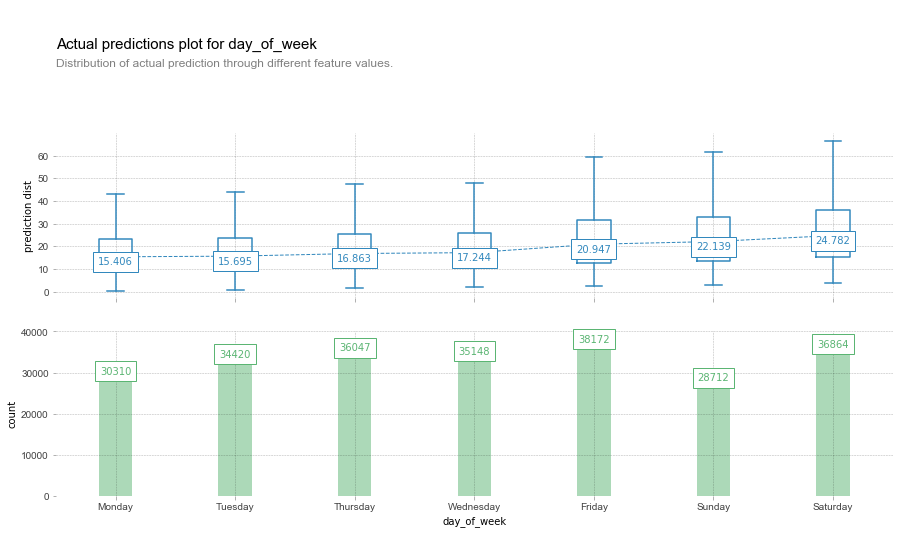

In [15]:
# this chart summarizes the model predictions made for each unique value in the day_of_week column
fig, axes, summary_df = info_plots.actual_plot(
    # notice these options -- accesing the appropriate parts of our pipeline to get the data setup
    model=pipe[1], X=pipe[0].transform(X_train), 
    feature='day_of_week', feature_name='day_of_week', predict_kwds={}
)

# this is just to get the tick marks to render correctly on the bottom
_ = axes['bar_ax'].set_xticklabels(['Monday', 'Tuesday', 'Thursday', 'Wednesday', 'Friday', 'Sunday', 'Saturday'])

In [121]:
# chart is being created from this variable
summary_df

,x,display_column,value_lower,value_upper,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,"[17.24, 17.72)",17.240350,17.720715,30310,9.944070,15.405807,23.151905
1,1,"[17.72, 18.93)",17.720715,18.929925,34420,10.146473,15.694589,23.727074
2,2,"[18.93, 19.23)",18.929925,19.231336,36047,10.767093,16.863035,25.508698
3,3,"[19.23, 23.02)",19.231336,23.021194,35148,10.893821,17.244491,25.828754
4,4,"[23.02, 23.84)",23.021194,23.842540,38172,12.704664,20.947307,31.528156
5,5,"[23.84, 26.25)",23.842540,26.250407,28712,13.485590,22.139427,32.758578
6,6,"[26.25, 26.25]",26.250407,26.250407,36864,15.303116,24.782447,35.851189


Now, let's build our actual PARTIAL DEPENDENCE PLOT.

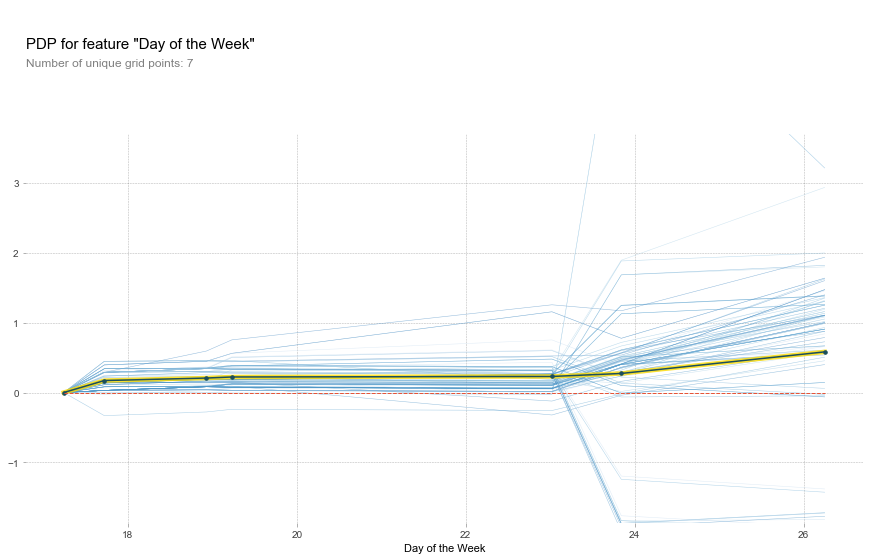

In [17]:
# what was the additive impact of EACH unique value of OverallQual?  What was its marginal impact?
pdp_day_of_week = pdp.pdp_isolate(
    model=pipe[1], dataset=pipe[0].transform(X_train), model_features=X_train.columns.tolist(), 
    feature='day_of_week', cust_grid_points = pipe[0].transform(X_train)['day_of_week'].tolist()
)

fig, axes = pdp.pdp_plot(pdp_day_of_week, 'Day of the Week', plot_lines=True, frac_to_plot=100)

### PDP for OneHot Encoded Columns

Lots of times your categorical data will be one hot encoded.  PDP plots render a bit more naturally if your data is setup this way, so it's a good idea to keep this in mind if you want to run these plots.  Let's setup our model to one hot encode the `genre` column and see how we can get these values to render.

In [23]:
# create a new pipeline -- this time onehot encoding the genre column
pipe = make_pipeline(ce.OneHotEncoder(cols=['city'], use_cat_names=True), ce.TargetEncoder(), GradientBoostingRegressor())
# fit our model again
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['city'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('targetencoder',
                 TargetEncoder(cols=['id', 'calendar_date', 'day_of_week',
                                     'genre', 'area'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_sampl...
                                           learning_rate=0.1, loss='ls',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_lea

In [34]:
# first, let's grab the columns with genre in them
city_cols = [col for col in pipe[0].get_feature_names() if 'city' in col]
city_cols

['city_Tōkyō',
 'city_Ōsaka',
 'city_Hyōgo',
 'city_Hiroshima',
 'city_Fukuoka',
 'city_Hokkaidō Sapporo',
 'city_Miyagi',
 'city_Niigata',
 'city_Hokkaidō Asahikawa',
 'city_Hokkaidō Abashiri',
 'city_Shizuoka',
 'city_Hokkaidō Katō']

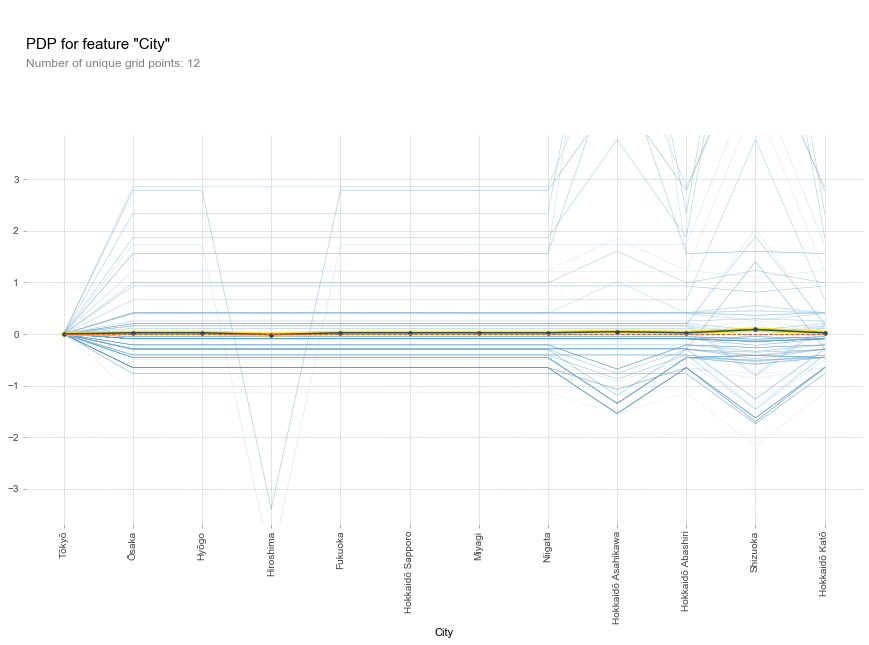

In [35]:
# and what about categorical variables?
# what was the impact of genre on attendance?
pdp_city = pdp.pdp_isolate(
                    # dataset -- create the final transformation of our data
    model=pipe[2], dataset=pipe[1].transform(pipe[0].transform(X_train)), model_features=pipe[1].get_feature_names(), 
    # this is the list of all the columns for the genre feature
    feature=city_cols
)

fig, axes = pdp.pdp_plot(pdp_city, 'City', plot_lines=True, frac_to_plot=100)
# this code is just for formatting -- getting the labels to format correctly
xtick_labels = [city.split('_')[1] for city in city_cols]
axes['pdp_ax'].set_xticklabels(xtick_labels, rotation='vertical');

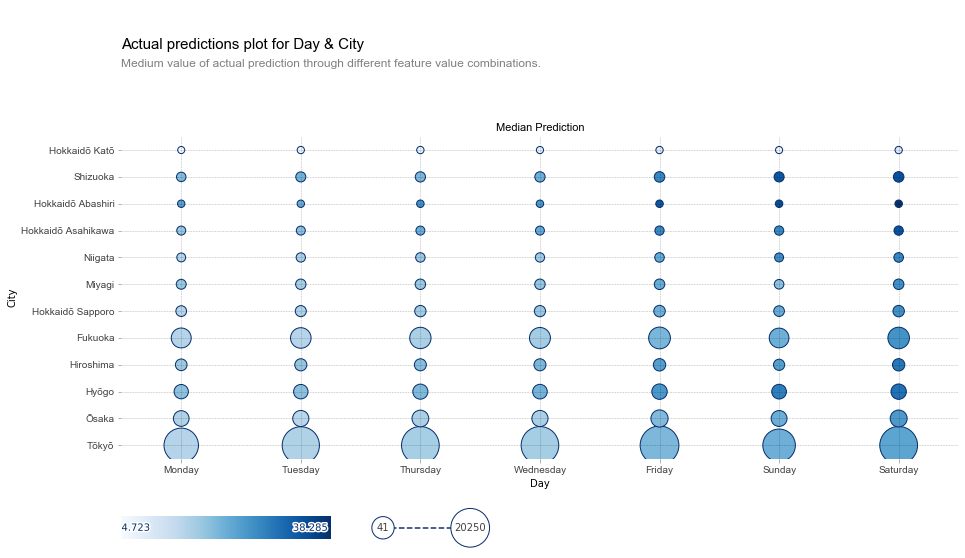

In [132]:
# and what about interactions?
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=pipe[2], X=pipe[1].transform(pipe[0].transform(X_train)), 
    features=['day_of_week', city_cols], 
    feature_names=['Day', 'City']
)

axes['value_ax'].set_yticklabels(xtick_labels);
axes['value_ax'].set_xticklabels(['Monday', 'Tuesday', 'Thursday', 'Wednesday', 'Friday', 'Sunday', 'Saturday']);

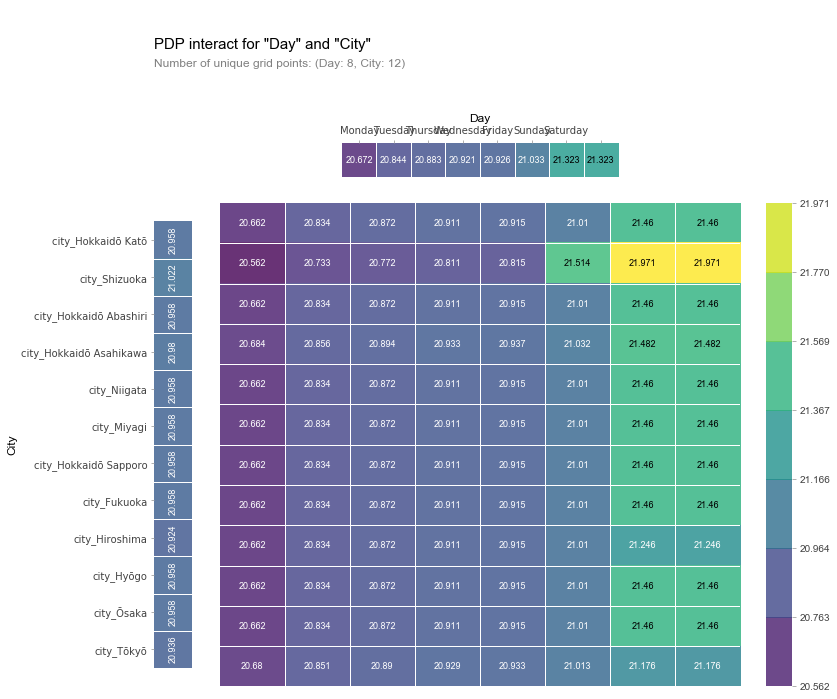

In [36]:
# and a slightly different look at the same problem
gbm_inter = pdp.pdp_interact(
    model=pipe[2], dataset=pipe[1].transform(pipe[0].transform(X_train)), model_features=pipe[1].get_feature_names(), 
    features=['day_of_week', city_cols]
)


fig, axes = pdp.pdp_interact_plot(
    gbm_inter, ['Day', 'City'], x_quantile=True, plot_type='grid', plot_pdp=True
)
axes['pdp_inter_ax']['_pdp_inter_ax'].set_xticklabels(['Monday', 'Tuesday', 'Thursday', 'Wednesday', 'Friday', 'Sunday', 'Saturday'], rotation='vertical');

In [150]:
# this is the dataset used to generate the above plot
gbm_inter.pdp

,day_of_week,city_Tōkyō,city_Ōsaka,city_Hyōgo,city_Hiroshima,city_Fukuoka,city_Hokkaidō Sapporo,city_Miyagi,city_Niigata,city_Hokkaidō Asahikawa,city_Hokkaidō Abashiri,city_Shizuoka,city_Hokkaidō Katō,preds
0,17.240350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20.662132
1,17.240350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20.561501
2,17.240350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,20.662132
3,17.240350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,20.684075
4,17.240350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20.662132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,26.250407,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.458351
92,26.250407,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.243519
93,26.250407,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.458351
94,26.250407,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.458351
